## Processing Ocean Color Imagery - Visualize Convert Images to Ocean Color

Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto
import pandas as pd

def load_img_fn_and_meta(img_dir, count, start):
    df = pd.read_csv(img_dir + '/log.csv')
    df['filename'] = df['SourceFile'].str.split('/').str[-1]
    df = df.set_index('filename')
    #print(df.head())
    i = 0
    j = 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.tif"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            md = gpsphoto.getGPSData(file)
            filename = file.split('/')[-1]
            md['filename'] = filename
            # this isn't correctly loaded into the exifdata so pulling it into my own md
            md['yaw']   = (df.loc[filename]['    GPSImgDirection'] + 360) % 360
            md['pitch'] = (df.loc[filename]['GPSPitch'] + 360) % 360
            md['roll']  = (df.loc[filename]['GPSRoll'] + 360) % 360
            
            img_metadata.append(md)
            j += 1
        i += 1
        
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

In [5]:
def brightest_tube_pix(img, percent=0.0001):
    brightest = []
    for band in range(0,5):
        flat_img = img[band].flatten()
        count = int(-1*len(flat_img)*percent)
        ind = np.argpartition(flat_img, count)[count:]
        brightest.append(np.mean(flat_img[ind]))
    print('brightest pixels used:', count*-1)
    return(brightest)

In [19]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.75, band=4, return_imgs=False, visualize=False, sky=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        print(i)
        if np.mean(imgs[i,0]) > 5 and not sky: # why am I doing this? I assume for thermal
            print(np.mean(imgs[i,0]))
            print('hitting this filter for brightness')
            continue
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        blue_spec = None
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
            if img_idx == 0:
                blue_spec = np.mean(sorted_band[idx])
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        #if blue_spec <0.02:
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)

In [20]:
def remove_bright_pix(im, lowest_percent=0.75, band=0):

    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=band, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    # cut out the super dark pix
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1 ] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [22]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    # TODO update this with the proper coefficients
    thresh = [0.15, 0.20]
    a0 = 0.1977
    a1 = -1.8117
    a2 = 1.9743
    a3 = 2.5635
    a4 = -0.7218

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [28]:
def vec_chla_img(blue, green):
    a0 = 0.1977
    a1 = -1.8117
    a2 = 1.9743
    a3 = 2.5635
    a4 = -0.7218

    log10chl = a0 + a1 * (np.log10(blue / green)) \
        + a2 * (np.log10(blue / green))**2 \
            + a3 * (np.log10(blue / green))**3 \
                + a4 * (np.log10(blue / green))**4

    oc3m = np.power(10, log10chl)
    return(oc3m)

In [30]:
def chla_img(sky_spectra, dark_pix, wind_speed = 5):
    dp_shape = dark_pix.shape
    sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (5,1))
    water_leaving = dark_pix.reshape(5,-1) - sky_rad_correction
    
#     chlas = []
#     for i in range(water_leaving.shape[-1]):
#         chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))
#     chlas = np.array(chlas)
#     return(chlas.reshape(dp_shape[1:3]))
    chla_vec = vec_chla_img(water_leaving[0], water_leaving[1])
    return(chla_vec.reshape(dp_shape[1:3]))
    

In [31]:
def visualize_chla_across_thresholds(im, sky_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_chla_img = chla_img(sky_spectra, dark_pix.reshape(im.shape), wind_speed = 5)
        
        ims = ax[i].imshow(full_chla_img, interpolation='nearest', cmap='jet', vmax=0.5)
        ax[i].set_title(lowest_percent)
        #current_cmap = matplotlib.cm.get_cmap()
        #current_cmap.set_bad(color='yellow')
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

In [32]:
def visualize_darkest_pixels(im, lowest_percent=0.5, band=0, max_clim=0.1, only_img=False):
    if im.shape[0] == 6: # because these are altum images
        im_flat = im[:-1].reshape(5,-1)
    else:
        im_flat = im.reshape(5,-1)
    # sort to get the darkest x pixels
    
    # visualize all bands and an RGB composite
    

    band_names = ['blue', 'green', 'red', 'red edge', 'nir']
    colors = ['blue', 'green', 'red', 'maroon', 'grey']
    
    fig, ax = plt.subplots(1,5, figsize=(16,14))
    for i,a in enumerate(ax):
        ims = a.imshow(im[i], cmap='jet', interpolation='none', vmax=max_clim, vmin=0)
        a.set_title(band_names[i])
        fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
        a.set_xticks([])
        a.set_yticks([])
#     ims = ax[5].imshow(im[0]/im[1], cmap='jet', vmax=10, vmin=0)
#     ax[5].set_title('blue/green')
#     ax[5].set_xticks([])
#     ax[5].set_yticks([])
#     fig.colorbar(ims, ax=ax[5], fraction=0.046, pad=0.04)
    #plt.savefig('openoceanfull.png')
    fig.show()
        
    if not only_img:
        
        # visualize all bands with the darkest pixels removed
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=band)


        fig, ax = plt.subplots(1,5, figsize=(16,14))
        for i,a in enumerate(ax):
            ims = a.imshow(dark_pix[i].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=max_clim, vmin=0)
            a.set_title(band_names[i])
            fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig('openoceanfilter.png')
        fig.show()


        fig, ax = plt.subplots(figsize=(12,8))
        colors = ['blue', 'green', 'red', 'grey', 'black']
        for i in range(0,5):
            ax.hist(dark_pix[i].flatten(), density=True, bins=50, color=colors[i], alpha=0.5)

        for i in range(0,5):
            print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)

        return(dark_pix.reshape(5,im.shape[1], im.shape[2]))
    else:
        return(None)

### Primary Processing Function

In [6]:
import math

def retrieve_imgs_and_metadata(img_dir, count=None, start=0, altitude_cutoff = 0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    idxs = []
    for i, md in enumerate(img_metadata):
        if md['Altitude'] > altitude_cutoff:
            idxs.append(i)
    
    imgs = load_images([img_fns[i] for i in idxs])
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    # TODO confirm with Anna that this is appropriate
    img = imgs / math.pi # this corrects from reflectance to remote sensing reflectance
    print('Output shape is: ', imgs.shape)

    # give the metadata the index of each image it is connected to so that I can sort them later
    img_metadata = [img_metadata[i] for i in idxs]
    i = 0
    for md in img_metadata:
        md['id'] = i
        i += 1
    return(imgs, img_metadata)

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [7]:
! ls data/20210404_duml_rho_correction_testing/

0009SET  panel	sky  sun_blocked  surface


In [8]:
blocked_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'sun_blocked', 'stacks')
surface_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'surface', 'stacks')
sky_dir = os.path.join('data', '20210404_duml_rho_correction_testing', 'sky', 'stacks')

In [9]:
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=100, start=0, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (16, 5, 947, 1267)


In [10]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_dir, count=100, start=0, altitude_cutoff=0)

Output shape is:  (7, 5, 947, 1267)


In [11]:
blocked_imgs, blocked_img_metadata = retrieve_imgs_and_metadata(blocked_dir, count=100, start=0, altitude_cutoff=0)

Output shape is:  (7, 5, 947, 1267)


In [12]:
def key_function(item_dictionary):
    '''Extract datetime string from given dictionary, and return the parsed datetime object'''
    datetime_string = item_dictionary['UTC-Time']
    return datetime.datetime.strptime(datetime_string, '%H:%M:%S')

In [13]:
sea_img_metadata.sort(key=key_function)

In [14]:
sky_img_metadata.sort(key=key_function)

In [15]:
blocked_img_metadata.sort(key=key_function)

only grab metadata

In [14]:
fns, mds = load_img_fn_and_meta(surface_dir, count=None, start=0)

In [15]:
mds[0]

{'Latitude': 34.71673611111111,
 'Longitude': -76.67349166666668,
 'Altitude': 1.9,
 'UTC-Time': '18:27:19',
 'Date': '03/30/2021',
 'filename': 'jz0JNiy0rjpbG2ocykBR.tif',
 'yaw': 274.74837839976607,
 'pitch': 23.98295930007771,
 'roll': 345.0410321830692}

In [16]:
len(mds)

50

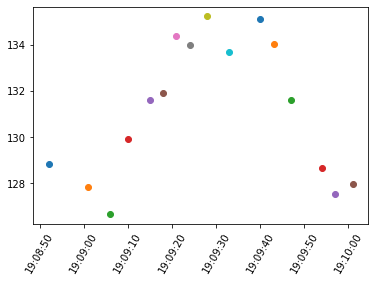

In [20]:
import datetime

for md in sea_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

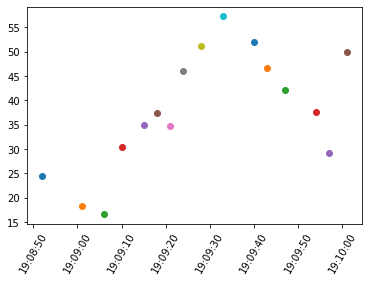

In [21]:
for md in sea_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

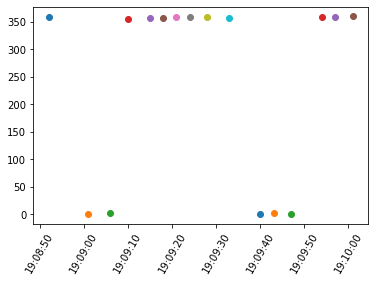

In [22]:
for md in sea_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['roll'])
    plt.xticks(rotation=60)

In [22]:
sea_imgs.nbytes / 1e9

0.90899648

In [23]:
sky_imgs.nbytes / 1e9

0.43057728

In [17]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

Inspect the bands either through time or sorted by pitch/yaw/lat/ etc

In [ ]:
sea_img_md_pitch_sort = sorted(sea_img_metadata[:], key=lambda k: k['pitch'])

sky_img_md_pitch_sort = sorted(sky_img_metadata[:], key=lambda k: k['pitch'])

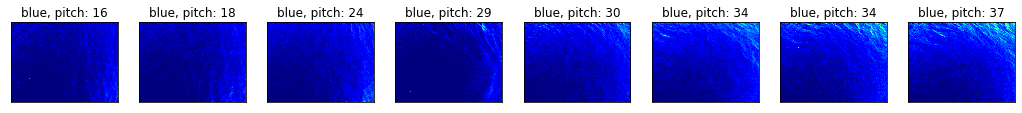

In [56]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue, pitch: ' + str(int(sea_img_md_pitch_sort[i]['pitch'])))
    im = ax[i].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


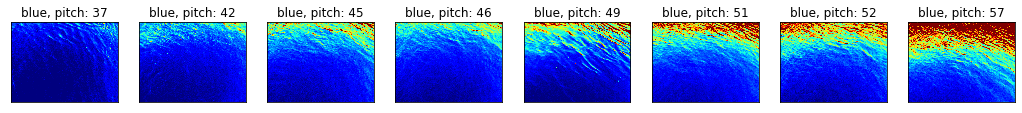

In [57]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue, pitch: ' + str(int(sea_img_md_pitch_sort[i+8]['pitch'])))
    im = ax[i].imshow(sea_imgs[sea_img_md_pitch_sort[i+8]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


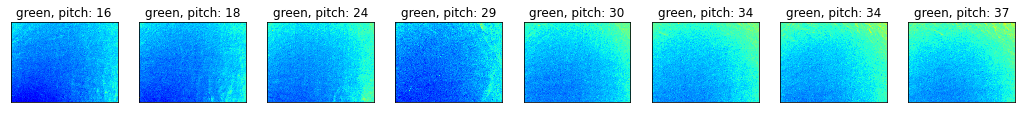

In [58]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green, pitch: ' + str(int(sea_img_md_pitch_sort[i]['pitch'])))
    im = ax[i].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

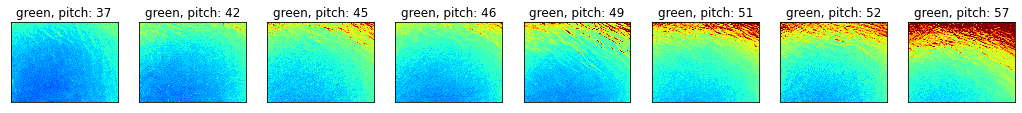

In [59]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green, pitch: ' + str(int(sea_img_md_pitch_sort[i+8]['pitch'])))
    im = ax[i].imshow(sea_imgs[sea_img_md_pitch_sort[i+8]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [63]:
sky_img_md_pitch_sort= sorted(sky_img_metadata[:], key=lambda k: k['pitch']) 
len(sky_img_md_pitch_sort)

7

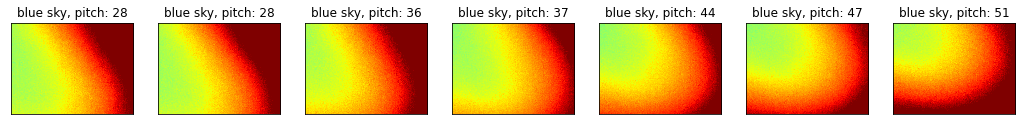

In [64]:
fig, ax = plt.subplots(1,7, figsize=(18,3))
for i in range(0,7):
    ax[i].set_title('blue sky, pitch: ' + str(int(sky_img_md_pitch_sort[i]['pitch'])))
    im = ax[i].imshow(sky_imgs[sky_img_md_pitch_sort[i]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

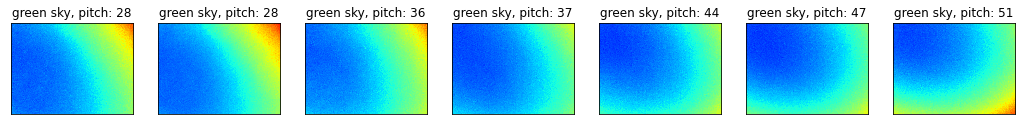

In [65]:
fig, ax = plt.subplots(1,7, figsize=(18,3))
for i in range(0,7):
    ax[i].set_title('green sky, pitch: ' + str(int(sky_img_md_pitch_sort[i]['pitch'])))
    im = ax[i].imshow(sky_imgs[sky_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### inspect the sun blocked spectra based on the brightest pics there

In [94]:
blocked_imgs.shape

(7, 5, 945, 1268)

brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119
brightest pixels used: 119


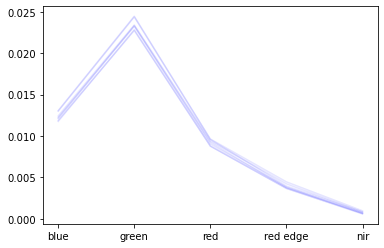

In [18]:
blocked_spectra = []
for i in range(0,7):
    spec = brightest_tube_pix(blocked_imgs[i])
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

#### inspect some bands after trimming the brightest picss

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


959879
959879
959879
959879
959879


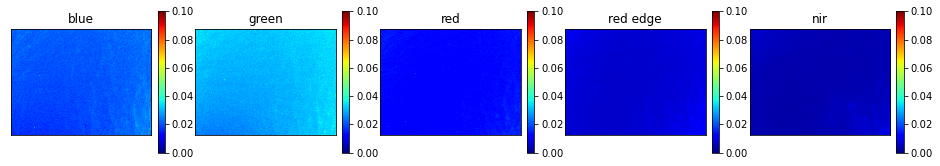

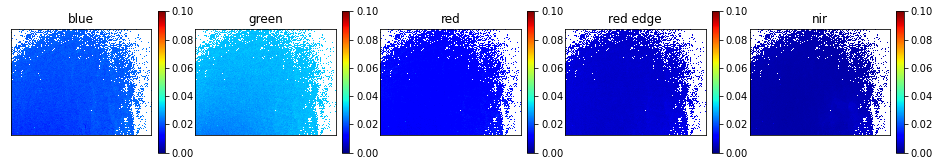

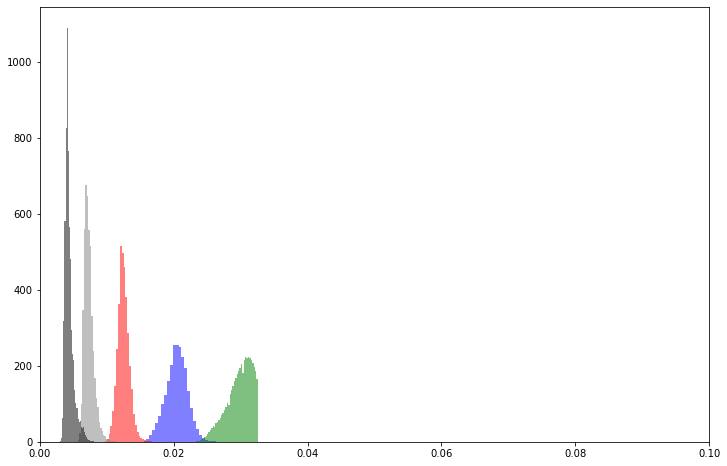

In [35]:
lowest_percent = 0.80
dark_pix_dark = visualize_darkest_pixels(sea_imgs[0], lowest_percent=lowest_percent, band=1)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


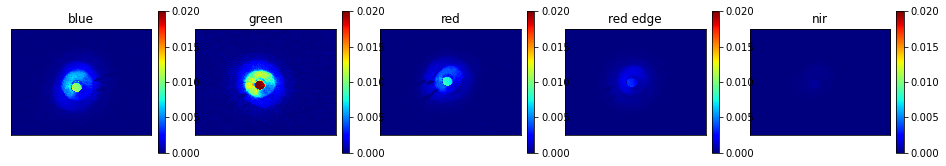

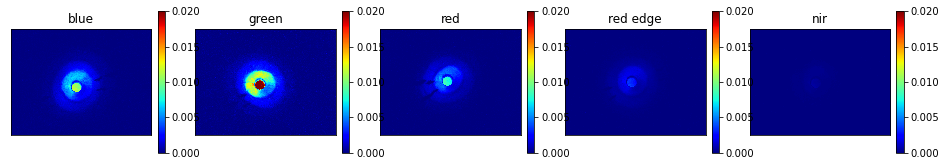

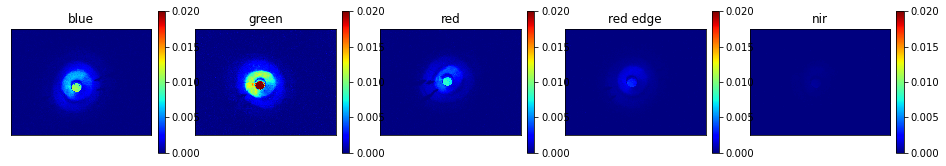

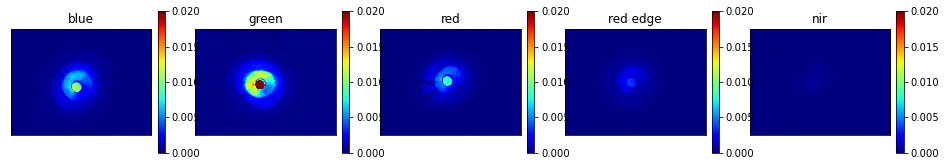

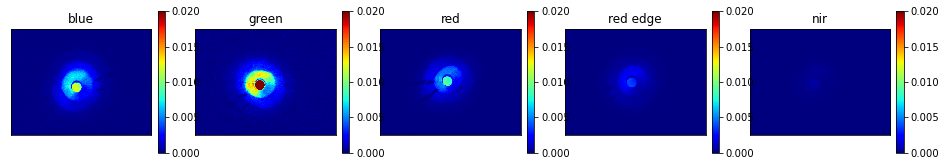

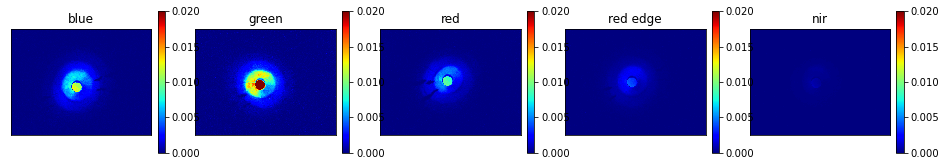

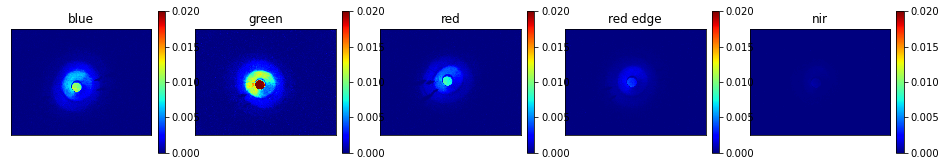

In [36]:
for i in range(0,7):
    visualize_darkest_pixels(blocked_imgs[i], lowest_percent=1, max_clim=0.02, only_img=True)

In [ ]:
for i in range(0,8):
    visualize_darkest_pixels(sea_imgs[i], lowest_percent=.8, only_img=False)

### Correct for sun glint

TODO currently just averaging sky spectra for removal but could easily interpolate across and incorporate time into which is chosen

This is the old approach based on ruddick and Mobley

In [41]:
def sun_glint_removal(sea_spectra, sky_spectra, wind_speed, method='ruddick2006'):
    sky_spectra = np.median(sky_spectra,axis=0)
    water_leaving_spectra = []
    # TODO will add in Zhang and other approaches
    print((0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed))
    if method == 'ruddick2006':
        for water_spec in sea_spectra:
            water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed)
            #water_leaving = water_leaving - water_leaving[4]
            # TODO if red edge is greater than ~.1 then it is cloudy and don't need wind correction just use 0.0256
            water_leaving_spectra.append(water_leaving)
    return(water_leaving_spectra)

### This is the current approach to calculating rho based on sunblocked spectra

In [5]:
import scipy.ndimage as ndimage

In [3]:
def calculate_rho(sea_imgs, sky_imgs, blocked_spec, visualize=True):
    # sea and sky img arrays are shape [img count, bands, rows, cols]
    # TODO calculate blurred sea and blurred sky for multiple images
    # TODO this could also be a surface fit to the image
    Lt_smooth_imgs = []
    for i in sea_imgs.shape[0]:
        Lt_smooth = ndimage.gaussian_filter(sea_imgs[i], sigma=(0, 60, 60), order=0)
        Lt_smooth_imgs.append(Lt_smooth)
    print(np.array(Lt_smooth_imgs).shape)
    Lt_smooth = np.mean(np.array(Lt_smooth_imgs), axis=0)
    # get lt minus lw
    Lt_Lw = (Lt_smooth.T - blocked_spec).T

    Lsky_smooth_imgs = []
    for i in sky_imgs.shape[0]:
        # flip lsky because the lowest part of the sea img is reflecting off the highest part of the sky
        Lsky = sky_imgs[i,:,::-1,:] # this flips the rows
        # smooth it out TODO could fit a surface to this too
        Lsky_smooth = ndimage.gaussian_filter(Lsky, sigma=(0, 20, 20), order=0)
        Lsky_smooth_imgs.append(Lsky_smooth)
        
    Lsky_smooth = np.mean(np.array(Lsky_smooth_imgs), axis=0)
    
    # divide this by the smoothed lsky
    rho = Lt_Lw / Lsky_smooth
    
    if visualize:
        fig, ax = plt.subplots(4,5, figsize=(18,16))
        for i in range(5):
            im = ax[0,i].imshow(Lt_smooth[i],cmap='jet', vmin=0.001, vmax=.04)
            fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            ax[0,i].set_title('original Lt')

            im = ax[1,i].imshow(Lt_Lw[i],cmap='jet', vmin=0.0, vmax=.02)
            fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            ax[1,i].set_title('lt - lw (spec)')

            im = ax[2,i].imshow(Lsky_smooth[i],cmap='jet', vmin=0.05, vmax=.2)
            fig.colorbar(im, ax=ax[2,i], fraction=0.046, pad=0.04)
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
            ax[2,i].set_title('lsky smooth (flip)')

            im = ax[3,i].imshow(rho[i],cmap='jet', vmin=0.0, vmax=.15)
            fig.colorbar(im, ax=ax[3,i], fraction=0.046, pad=0.04)
            ax[3,i].set_xticks([])
            ax[3,i].set_yticks([])
            ax[3,i].set_title('rho')
            fig.show()
        
    return(rho)

In [4]:
def apply_rho(sea_img, sky_img, rho, visualize=True):

    # flip lsky because the lowest part of the sea img is reflecting off the highest part of the sky
    lsky = sky_img[:,::-1,:] # this flips the rows
    # smooth it out TODO could fit a surface to this too
    lsky_smooth = ndimage.gaussian_filter(lsky, sigma=(0, 20, 20), order=0)
    lw_img = sea_img - rho * lsky_smooth
    print(lw_img.shape)
    
    if visualize:
        fig, ax = plt.subplots(4,5, figsize=(18,16))
        for i in range(5):
            im = ax[0,i].imshow(sea_img[i],cmap='jet', vmin=0.001, vmax=.04)
            fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            ax[0,i].set_title('original Lt')


            im = ax[1,i].imshow(lsky_smooth[i],cmap='jet', vmin=0.05, vmax=.2)
            fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            ax[1,i].set_title('lsky smooth (flip)')

            im = ax[2,i].imshow(rho[i],cmap='jet', vmin=0.0, vmax=.15)
            fig.colorbar(im, ax=ax[2,i], fraction=0.046, pad=0.04)
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
            ax[2,i].set_title('rho')

            im = ax[3,i].imshow(lw_img[i],cmap='jet', vmin=0.001, vmax=.03)
            fig.colorbar(im, ax=ax[3,i], fraction=0.046, pad=0.04)
            ax[3,i].set_xticks([])
            ax[3,i].set_yticks([])
            ax[3,i].set_title('full lw')
            fig.show()
    return(lw_img)

### Apply that approach

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


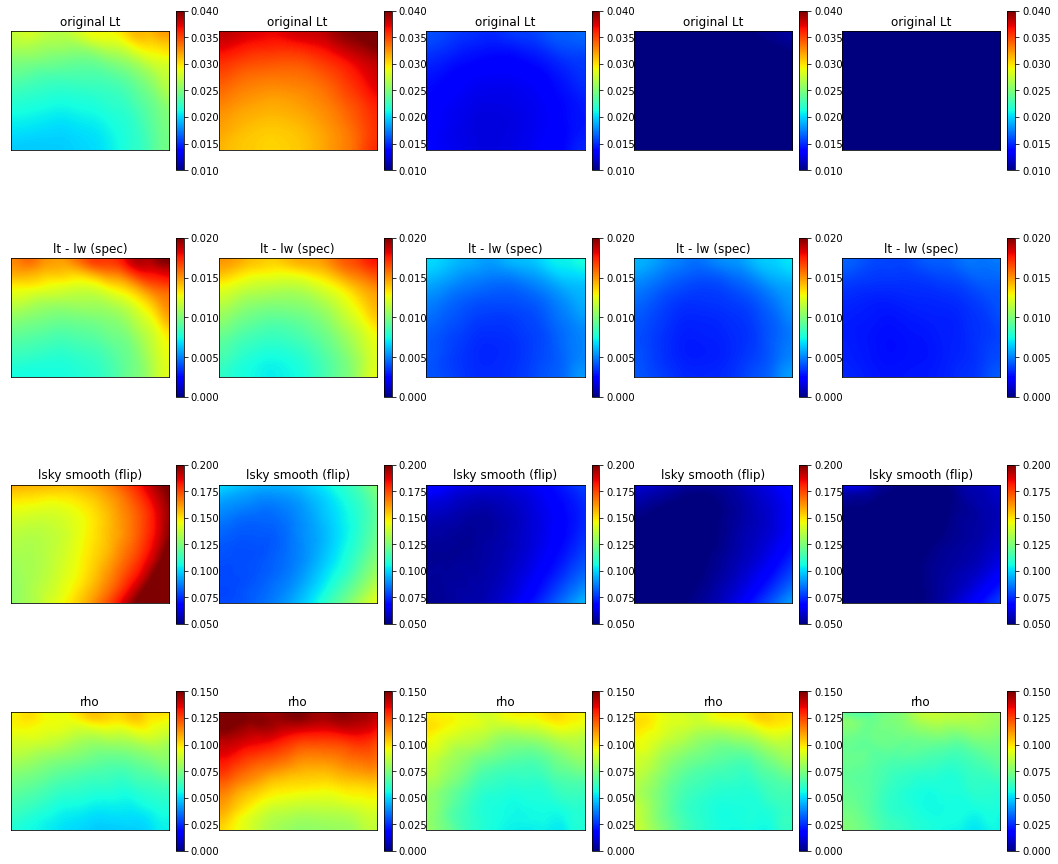

In [203]:
rho = calculate_rho(sea_imgs[sea_img_md_pitch_sort[7]['id']], 
              sky_imgs[sky_img_md_pitch_sort[3]['id']], 
              np.median(blocked_spectra,axis=0), visualize=True)

(5, 947, 1267)


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


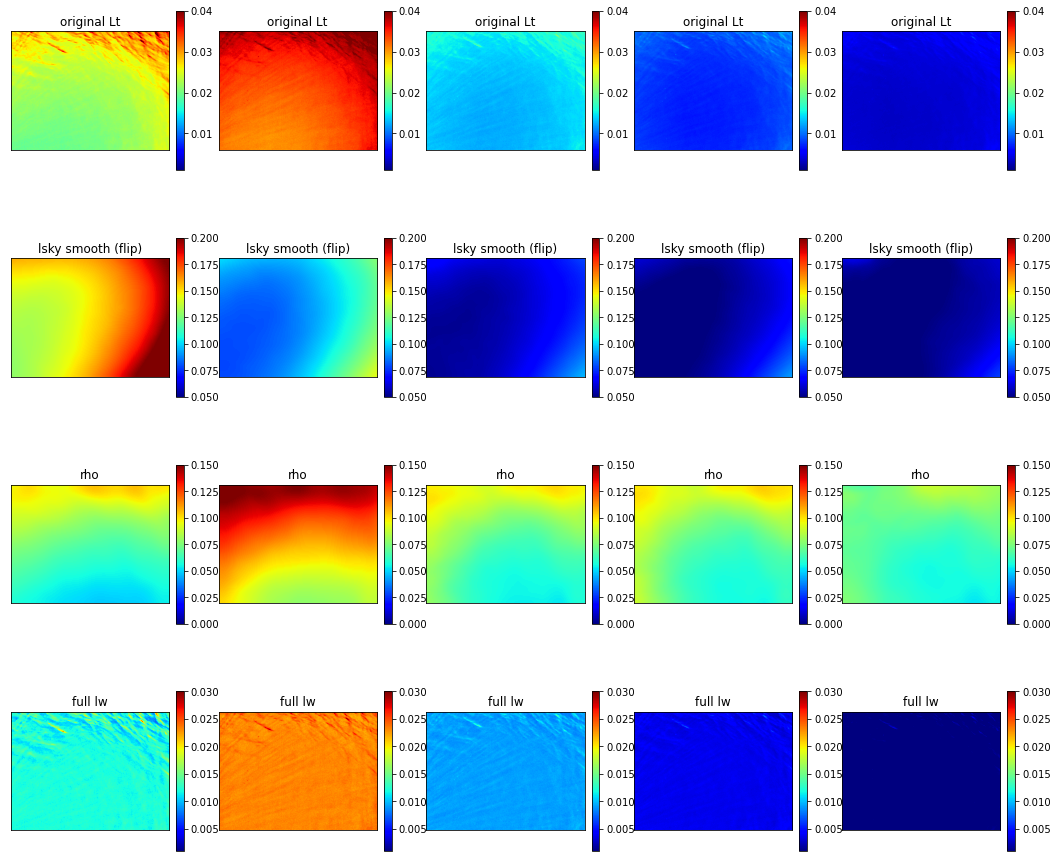

In [217]:
lw_processed = apply_rho(sea_imgs[sea_img_md_pitch_sort[7]['id']], 
              sky_imgs[sky_img_md_pitch_sort[3]['id']], rho, visualize=True)

#### Inspect the spectra from this

In [6]:
fig, ax = plt.subplots(figsize=(13,10))

for spectra in [np.median(sea_imgs[sea_img_md_pitch_sort[7]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='blue', alpha=0.5)
    
for spectra in [np.median(lw_processed,axis=(1,2))]:
    ax.plot(band_names, spectra, color='green', alpha=0.5)

for spectra in blocked_spectra:
    ax.plot(band_names, spectra, color='pink', alpha=0.5)
    
for spectra in [np.median(sky_imgs[sky_img_md_pitch_sort[3]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='lightblue', alpha=0.7)
    
#ax.plot(band_names, np.median(sky_spectra[0], axis=0), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

NameError: name 'plt' is not defined

#### What does chla look like from these images

In [87]:
chla_lw = vec_chla_img(blue_lw, green_lw)

In [98]:
chla_lw[300:, 100:-100].shape

(647, 1067)

In [101]:
np.median(chla_lw)

6.3816071756413475

In [102]:
np.median(chla_lw[300:, 100:-100])

6.365109877580753

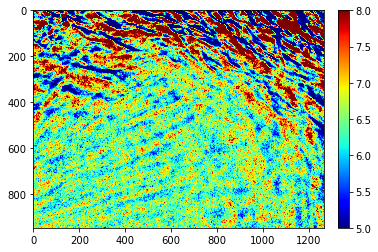

In [100]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=5,vmax=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

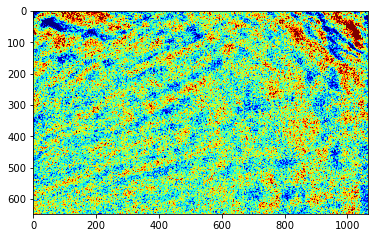

In [97]:
plt.imshow(chla_lw[300:, 100:-100], cmap='jet', vmin=5,vmax=8)

#### Now visualize a bunch of images and the chla from them

pitch: 0.7813185964237164
yaw: 304.93347128816885


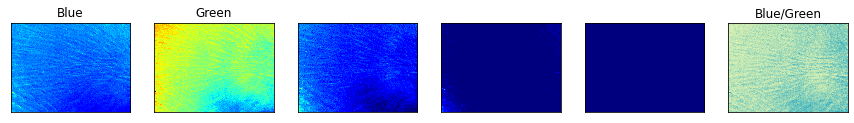

pitch: 2.8484284979807057
yaw: 302.53077525335925


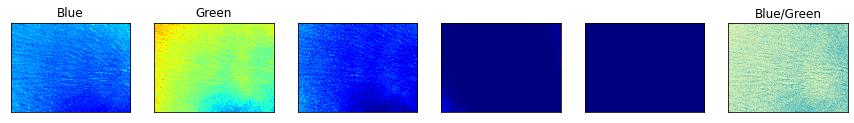

pitch: 3.6206177658294223
yaw: 301.4414487410652


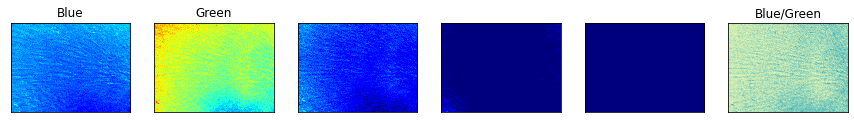

pitch: 4.721692730735867
yaw: 298.1653482965328


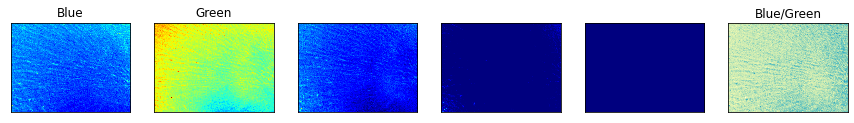

pitch: 5.120128671639236
yaw: 305.2211089662284


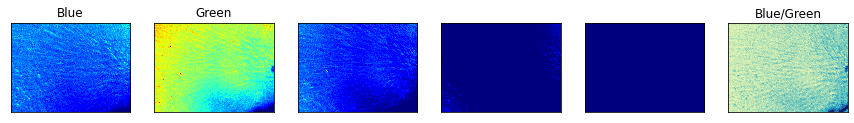

pitch: 8.867759744493128
yaw: 297.4514476679033


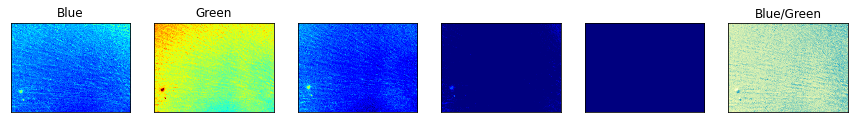

pitch: 14.537520990904625
yaw: 295.0259268435857


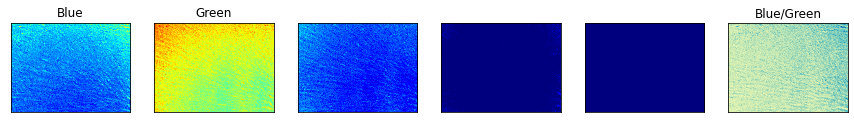

pitch: 14.72927694587986
yaw: 294.3668642045996


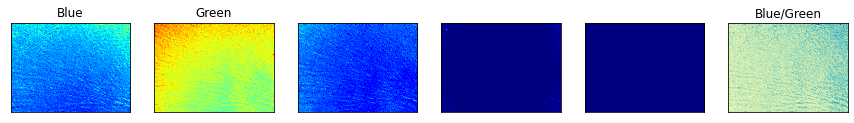

pitch: 18.58987542005042
yaw: 300.68554398471616


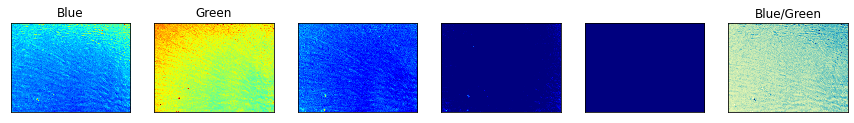

pitch: 21.552289944880386
yaw: 295.5408153471316


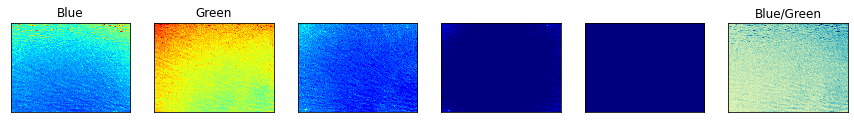

pitch: 28.688788660328328
yaw: 298.0796696209331


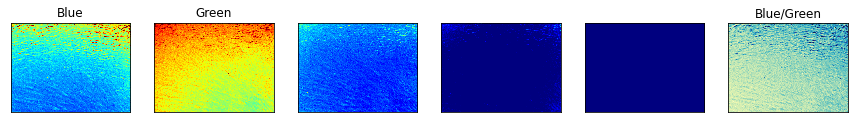

pitch: 30.059735205448305
yaw: 294.63023903277116


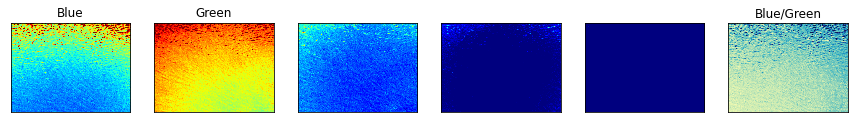

pitch: 31.532183905804573
yaw: 294.6144682255024


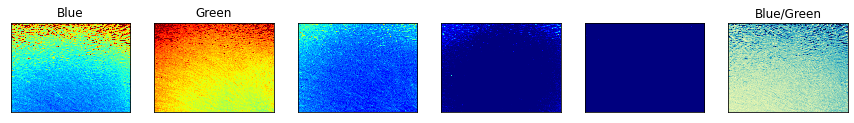

pitch: 35.50975389693423
yaw: 296.20690213826157


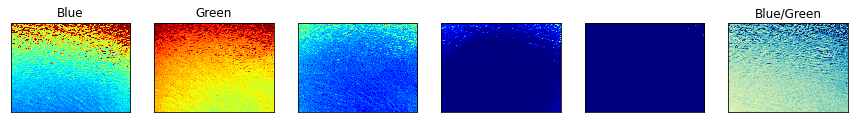

pitch: 38.21853591894268
yaw: 292.7428469723451


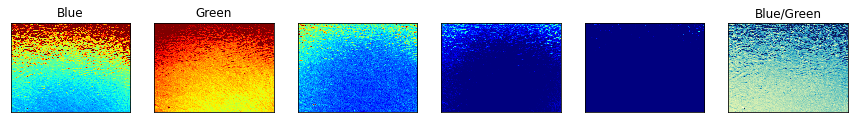

pitch: 42.79733112679867
yaw: 294.99385912732583


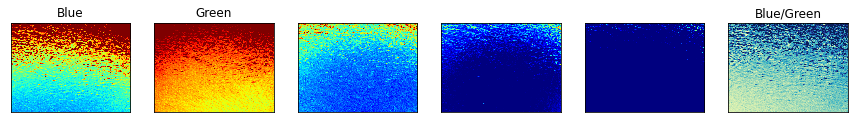

pitch: 46.578352076488784
yaw: 292.1382280748443


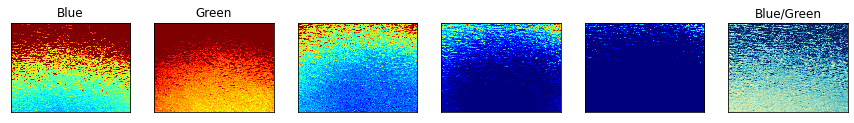

pitch: 50.35286895742746
yaw: 291.97495226550814


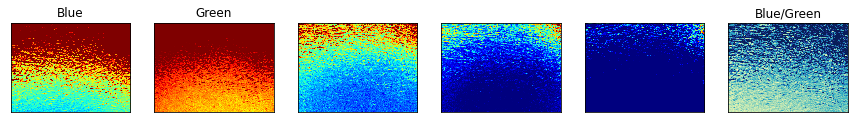

pitch: 58.804622029358086
yaw: 287.4272326639197


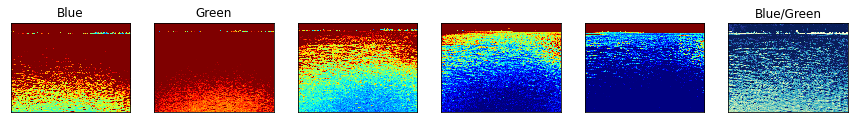

In [225]:
for i in range(0,19):
    fig, ax = plt.subplots(1,6, figsize=(15,3))
    print('pitch:',sea_img_md_pitch_sort[i]['pitch'])
    print('yaw:',sea_img_md_pitch_sort[i]['yaw'])
    ax[0].set_title("Blue")
    im = ax[0].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    #fig.colorbar(im,ax=ax[0])
    ax[1].set_title("Green")
    im2 = ax[1].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    #fig.colorbar(im2,ax=ax[1])
    im3 = ax[2].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],2], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    #fig.colorbar(im2,ax=ax[2])
    im4 = ax[3].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],3], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    #fig.colorbar(im2,ax=ax[3])
    im5 = ax[4].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],4], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[5].set_title("Blue/Green")
    im6 = ax[5].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0]/sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='YlGnBu', vmin=.5, vmax=1.2)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    #fig.colorbar(im2,ax=ax[4])
    plt.show()

### Chlorophyll retrieval algorithm

Run chla retrieval on water leaving spectra

In [66]:
chla_list = []
for spectra in blocked_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[6.356087606017864,
 6.258882462214956,
 6.555905398674276,
 6.437045009156115,
 6.0705909634053805,
 6.0467082739748275,
 6.1363390346805025]

In [67]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[3.725178152219733]

In [294]:
4.50674749003831 / 3.778

1.1928924007512731

In [68]:
for md in sea_img_metadata[:]:
    print(md['pitch'])

24.48100439092184
18.278774752899437
16.62868657249811
30.335922246084635
34.914430565022315
37.5013787624174
34.73575007534288
45.9768427574661
51.218735490343306
57.236565622612886
52.02441024442453
46.67323453974166
42.0941159243867
37.69342367764301
29.24397755315249
49.92532694279146


### Save spectra and chla values as a geopandas dataframe along with image metadata

In [69]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [70]:
from datetime import datetime
import pandas as pd

def convert_to_ocean_color_gdf(chla_list, spectra_list, img_metadata):
    chla_dates = []
    for im in img_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']

        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        chla_dates.append(date_time_obj)
    lons = []
    lats = []
    alts = []
    for im in img_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        alts.append(im['Altitude'])
        
    chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'Altitude' : alts,
     'spectra' : spectra_list,
     'time' : chla_dates})

    chla_gdf = gpd.GeoDataFrame(
        chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
    
    return(chla_gdf)

In [ ]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])
print(len(gdf))
gdf.head()

In [ ]:
import contextily as ctx
gdf.set_crs(epsg=4326, inplace=True)
web_merc_gdf = gdf.to_crs(epsg=3857)
fig,ax = plt.subplots(figsize=(12,12))
web_merc_gdf.plot(ax=ax, column='chla', vmax=6, vmin=3)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax)
ctx.add_basemap(ax, zoom=12)
ax.set_ylim(4123102,4126102)
ax.set_xlim(-8537315, -8532315)

Save out the file

In [185]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')